# Getting started: MHE

In this Jupyter Notebook we illustrate application of the **do-mpc** moving horizon estimation module.
Please follow first the general **Getting Started** guide, as we cover the sample example and skip over some previously explained details.

In [1]:
import numpy as np
from casadi import *

# Add to path:
import sys
sys.path.append('../../')

# Import do_mpc package:
import do_mpc

## Creating the model

First, we need to decide on the model type. For the given example, we are working with a continuous model.

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### Model variables

The next step is to define the model variables. It is important to define the variable type, name and optionally shape (default is scalar variable). 

In contrast to the previous example, we now use vectors for all variables.


In [3]:
phi = model.set_variable(var_type='_x', var_name='phi', shape=(3,1))
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))

# Two states for the desired (set) motor position:
phi_m_set = model.set_variable(var_type='_u', var_name='phi_m_set', shape=(2,1))

# Two additional states for the true motor position:
phi_m = model.set_variable(var_type='_x', var_name='phi_m', shape=(2,1))

### Model measurements

This step is essential for the state estimation task: We must define a measurable output.
Typically, this is a subset of states (or a transformation thereof) as well as the inputs.

Note that some MHE implementations consider inputs separately.

In [4]:
# State measurements
phi_meas = model.set_meas('phi_1_meas', phi)

# Input measurements
phi_m_set_meas = model.set_meas('phi_m_set_meas', phi_m_set)

### Model parameters

Next we **define parameters**. The MHE allows to estimate parameters as well as states. Note that not all parameters must be estimated (as shown in the MHE setup below). We can also hardcode parameters (such as the spring constants `c`).

In [5]:
Theta_1 = model.set_variable('parameter', 'Theta_1') 
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

### Right-hand-side equation
Finally, we set the right-hand-side of the model by calling `model.set_rhs(var_name, expr)` with the `var_name` from the state variables defined above and an expression in terms of $x, u, z, p$. 

In [6]:
model.set_rhs('phi', dphi)

dphi_next = vertcat(
    -c[0]/Theta_1*(phi[0]-phi_m[0])-c[1]/Theta_1*(phi[0]-phi[1])-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi[1]-phi[0])-c[2]/Theta_2*(phi[1]-phi[2])-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi[2]-phi[1])-c[3]/Theta_3*(phi[2]-phi_m[1])-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)

tau = 1e-2 
model.set_rhs('phi_m', 1/tau*(phi_m_set - phi_m))


The model setup is completed by calling `model.setup_model()`:

In [7]:
model.setup_model()

After calling `model.setup_model()` we cannot define further variables etc.

## Configuring the Moving Horizon Estimator
The first step of configuring the moving horizon estimator is to call the class with a list of all parameters to be estimated. An empty list (default value) means that no parameters are estimated.
The list of estimated parameters must be a subset (or all) of the previously defined parameters.

<div class="alert alert-info">
**Note** 
    
So why did we define ``Theta_2`` and ``Theta_3`` if we do not estimate them?

In many cases we will use the same model for (robust) control and MHE estimation. In that case it is possible to have some external parameters (e.g. weather prediction) that are uncertain but cannot be estimated. 
</div>

In [8]:
mhe = do_mpc.estimator.MHE(model, ['Theta_1'])

### MHE parameters:
Next, we pass MHE parameters. Most importantly, we need to set the time step and the horizon.
We also choose to obtain the measurement from the MHE data object. 
Alternatively, we are able to set a user defined measurement function that is called at each timestep and returns the `N` previous measurements for the estimation step.

In [9]:
setup_mhe = {
    't_step': 0.1,
    'n_horizon': 10,
    'store_full_solution': True,
    'meas_from_data': True
}
mhe.set_param(**setup_mhe)

### Cost Function
The most important step of the configuration is to define the MHE cost function. 
The **do-mpc** MHE implementation allows maximum flexiblity in that sense.
We retrieve the variables ``_y_meas``, ``_y_calc``, ``_x_prev``, ``_x``, ``_p_est``, ``_p_est_prev``
and formulate the stage cost (as a function of ``_y_meas``, ``_y_calc``) and the arrival cost (as a function of (``_x_prev``, ``_x``, ``_p_est``, ``_p_est_prev``). 
Typically, we want to formulate the following objective:

$$
J=  &\underbrace{(x_0 - \tilde{x}_0)^T P_x (x_0 - \tilde{x}_0)}_{\text{arrival cost states}} +
           \underbrace{(p_0 - \tilde{p}_0)^T P_p (p_0 - \tilde{p}_0)}_{\text{arrival cost params.}} \\
            &+\sum_{k=0}^{n-1} \underbrace{(h(x_k, u_k, p_k) - y_k)^T P_{y,k} (h(x_k, u_k, p_k) - y_k)}_{\text{stage cost}}
$$

In [10]:
y_meas = mhe._y_meas
y_calc = mhe._y_calc

dy = y_meas.cat-y_calc.cat
P_y = np.diag(np.array([1,1,1,20,20]))

stage_cost = dy.T@P_y@dy

x_0 = mhe._x
x_prev = mhe._x_prev
p_0 = mhe._p_est
p_prev = mhe._p_est_prev

dx = x_0.cat - x_prev.cat
dp = p_0.cat - p_prev.cat

P_x = np.eye(8)
P_p = np.eye(1)

arrival_cost = 1e-4*dx.T@P_x@dx + 1e-4*dp.T@P_p@dp


mhe.set_objective(stage_cost, arrival_cost)

### Fixed parameters
If the model contains parameters and if we estimate only a subset of these parameters, it is required to pass a function that returns the value of the remaining parameters at each time step. 

Furthermore, this function must return a specific structure, which is first obtained by calling:

In [11]:
p_template_mhe = mhe.get_p_template()

Using this structure, we then formulate the following function for the remaining (not estimated) parameters:

In [12]:
def p_fun_mhe(t_now):
    p_template_mhe['Theta_2'] = 2.25e-4
    p_template_mhe['Theta_3'] = 2.25e-4
    return p_template_mhe

This function is finally passed to the ``mhe`` instance:

In [13]:
mhe.set_p_fun(p_fun_mhe)

### Bounds
The MHE implementation also supports bounds for states, inputs, parameters which can be set as shown below.
For the given example, it is especially important to set realistic bounds on the estimated parameter. Otherwise the MHE solution is a poor fit.

In [14]:
mhe.bounds['lower','_u', 'phi_m_set'] = -2*np.pi
mhe.bounds['upper','_u', 'phi_m_set'] = 2*np.pi

mhe.bounds['lower','_p_est', 'Theta_1'] = 1e-5
mhe.bounds['upper','_p_est', 'Theta_1'] = 1e-3

### Setup
Similar to the controller, simulator and model, we finalize the MHE configuration by calling:

In [15]:
mhe.setup()

## Configuring the Simulator
In many cases, a developed control approach is first tested on a simulated system. **do-mpc** responds to this need with the `do_mpc.simulator` class. The `simulator` uses state-of-the-art DAE solvers, e.g. Sundials [CVODE](https://computing.llnl.gov/projects/sundials/cvode) to solve the DAE equations defined in the supplied `do_mpc.model`. This will often be the same model as defined for the `optimizer` but it is also possible to use a more complex model of the same system.

In this section we demonstrate how to setup the `simulator` class for the given example. We initialize the class with the previously defined `model`:

In [16]:
simulator = do_mpc.simulator.Simulator(model)

### Simulator parameters

Next, we need to parametrize the `simulator`. Please see the API documentation for `simulator.set_param()` for a full description of available parameters and their meaning. Many parameters already have suggested default values. Most importantly, we need to set `t_step`. We choose the same value as for the `optimizer`.

In [17]:
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

### Parameters
In the `model` we have defined the inertia of the masses as parameters. The `simulator` is now parametrized to simulate using the "true" values at each timestep. In the most general case, these values can change, which is why we need to supply a function that can be evaluted at each time to obtain the current values. 
**do-mpc** requires this function to have a specific return structure which we obtain first by calling:

In [18]:
p_template_sim = simulator.get_p_template()

We need to define a function which returns this structure with the desired numerical values. For our simple case:

In [19]:
def p_fun_sim(t_now):
    p_template_sim['Theta_1'] = 2.25e-4
    p_template_sim['Theta_2'] = 2.25e-4
    p_template_sim['Theta_3'] = 2.25e-4
    return p_template_sim

This function is now supplied to the `simulator` in the following way:

In [20]:
simulator.set_p_fun(p_fun_sim)

### Setup
Finally, we call:

In [21]:
simulator.setup()

## Creating the loop
While the full loop should also include a controller, we are currently only interested in showcasing the estimator. We therefore estimate the states for an arbitrary initial condition and some random control inputs (shown below).

In [22]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -5, 5, 0, 0]).reshape(-1,1)

To make things more interesting we pass the estimator a perturbed initial state:

In [23]:
x0_mhe = x0*(1+0.5*np.random.randn(8,1))

and use the `.set_initial_state()` method to set the initial state:

In [24]:
simulator.set_initial_state(x0, reset_history=True)
mhe.set_initial_state(x0_mhe ,p_est0=np.array([1e-4]), reset_history=True)

### Setting up the Graphic
We are again using the **do-mpc** `graphics` module. This versatile tool allows us to conveniently configure a user-defined plot based on Matplotlib and visualize the results stored in the `mhe.data`, `simulator.data` objects. 

We start by importing matplotlib:

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

And initializing the `graphics module`:

In [26]:
graphics = do_mpc.graphics.Graphics()

Next, we create a `figure` and obtain its `axis` object. Matplotlib offers multiple alternative ways to obtain an `axis` object, e.g. [subplots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html), [subplot2grid](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html), or simply [gca](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html). We use `subplots`:

In [27]:
%%capture 
# We just want to create the plot and not show it right now. This "inline magic" surpresses the output.
fig, ax = plt.subplots(3, sharex=True, figsize=(16,9))
fig.align_ylabels()

# We create another figure to plot the parameters:
fig_p, ax_p = plt.subplots(1, figsize=(16,4))

Most important API element for setting up the `graphics` module is `graphics.add_line`, which mimics the API of `model.add_variable`, except that we also need to pass an `axis`. 

Note that we are only configuring the `graphics` module without showing anything just yet.

In [28]:
%%capture
# Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
graphics.add_line(var_type='_x', var_name='phi', axis=ax[0])
ax[0].set_ylabel('angle \n position [rad]')

graphics.add_line(var_type='_x', var_name='dphi', axis=ax[1])
ax[1].set_ylabel('angular \n velocity [rad/s]')

# Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
graphics.add_line(var_type='_u', var_name='phi_m_set', axis=ax[2])
ax[2].set_ylabel('motor \n angle [rad]')

ax[2].set_xlabel('time [s]')

graphics.add_line(var_type='_p', var_name='Theta_1', axis=ax_p)
graphics.add_line(var_type='_p', var_name='Theta_2', axis=ax_p)
graphics.add_line(var_type='_p', var_name='Theta_3', axis=ax_p)

### Running the loop
We investigate the closed-loop MHE performance by alternating a simulation step (`y0=simulator.make_step(u0)`) and an estimation step (`x0=mhe.make_step(y0)`). Since we are lacking the controller which would close the loop (`u0=mpc.make_step(x0)`), we define a random control input function:

In [29]:
def random_u(u0):
    # Hold the current value with 80% chance or switch to new random value.
    u_next = (0.5-np.random.rand(2,1))*np.pi # New candidate value.
    switch = np.random.rand() >= 0.8 # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

The function holds the current input value with 80% chance or switches to a new random input value.

We can now run the loop. At each iteration, we perturb our measurements with additive Gaussian noise,
for a more realistic scenario.

In [30]:
%%capture
np.random.seed(999) #make it repeatable

u0 = np.zeros((2,1))
for i in range(50):
    u0 = random_u(u0) # Control input
    y0 = simulator.make_step(u0) # true measurement
    y0 = y0*(1+0.1*np.random.randn(model.n_y,1)) # perturbed measurement
    x0 = mhe.make_step(y0) # MHE estimation step

We can visualize the resulting trajectory with the pre-defined graphic:

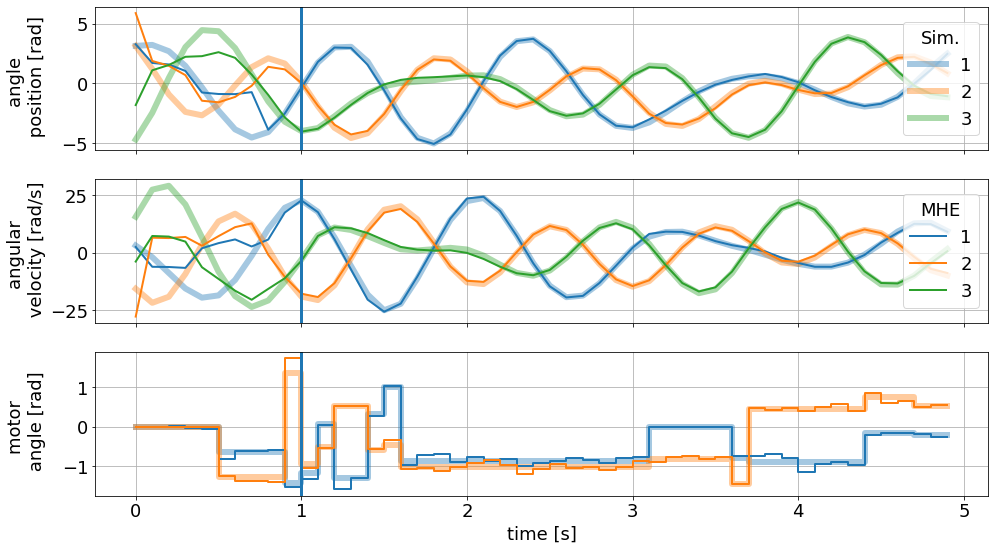

In [31]:
graphics.reset_axes()
sim_lines = graphics.plot_results(simulator.data, linewidth = 6, alpha =0.4, linestyle='-')
ax[0].legend(sim_lines[:3], '123', title='Sim.', loc='center right')
mhe_lines = graphics.plot_results(mhe.data, linewidth = 2, alpha = 1, linestyle='-')
ax[1].legend(mhe_lines[:3], '123', title='MHE', loc='center right')
# Mark the time after a full horizon is available to the MHE.
ax[0].axvline(1)
ax[1].axvline(1)
ax[2].axvline(1)

# Show the figure:
fig

Parameter estimation:

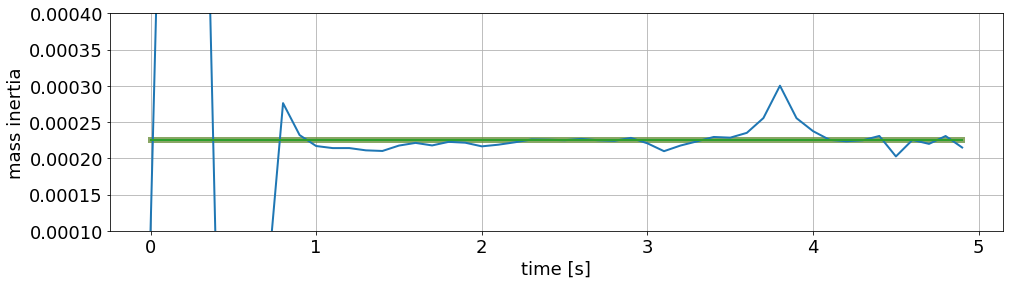

In [32]:
ax_p.set_ylim(1e-4, 4e-4)
ax_p.set_ylabel('mass inertia')
ax_p.set_xlabel('time [s]')
fig_p

## MHE Advantages

One of the main advantages of moving horizon estimation is the possibility to set bounds for states, inputs and estimated parameters. As mentioned above, this is crucial in the presented example. Let's see how the MHE behaves without realistic bounds for the estimated mass inertia of disc one. 

We simply reconfigure the bounds:

In [33]:
mhe.bounds['lower','_p_est', 'Theta_1'] = -np.inf
mhe.bounds['upper','_p_est', 'Theta_1'] = np.inf

And setup the MHE again. The backend is now recreating the optimization problem, taking into consideration the currently saved bounds.

In [34]:
mhe.setup()

We reset the history of the estimator and simulator (to clear their data objects and start "fresh").

In [35]:
mhe.reset_history()
simulator.reset_history()

Finally, we run the exact same loop again obtaining new results.

In [36]:
%%capture
np.random.seed(999) #make it repeatable

u0 = np.zeros((2,1))
for i in range(50):
    u0 = random_u(u0) # Control input
    y0 = simulator.make_step(u0) # true measurement
    y0 = y0*(1+0.1*np.random.randn(model.n_y,1)) # perturbed measurement
    x0 = mhe.make_step(y0) # MHE estimation step

These results now look quite terrible:

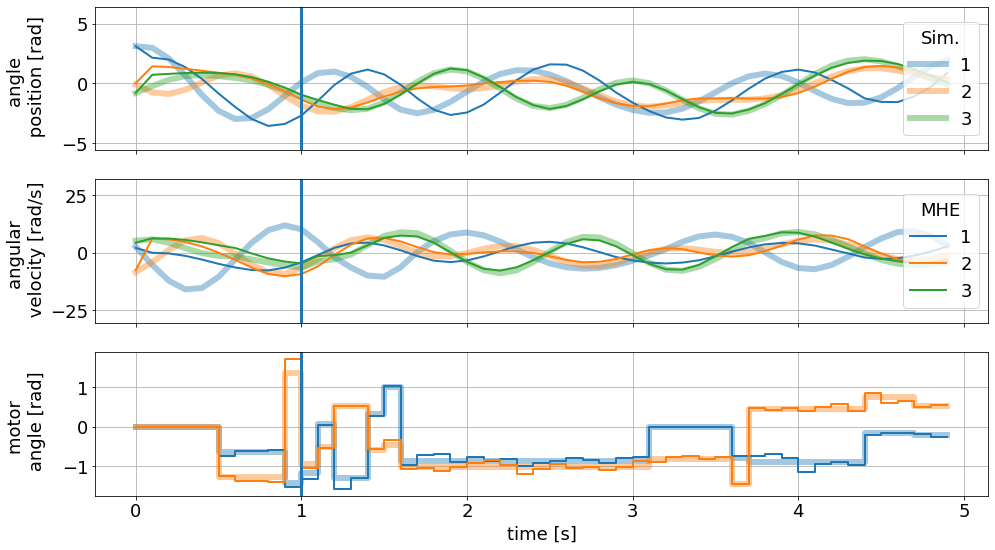

In [37]:
graphics.reset_axes()
sim_lines = graphics.plot_results(simulator.data, linewidth = 6, alpha =0.4, linestyle='-')
ax[0].legend(sim_lines[:3], '123', title='Sim.', loc='center right')
mhe_lines = graphics.plot_results(mhe.data, linewidth = 2, alpha = 1, linestyle='-')
ax[1].legend(mhe_lines[:3], '123', title='MHE', loc='center right')
# Mark the time after a full horizon is available to the MHE.
ax[0].axvline(1)
ax[1].axvline(1)
ax[2].axvline(1)

# Show the figure:
fig

Clearly, the main problem is a faulty parameter estimation, which is off by orders of magnitude:

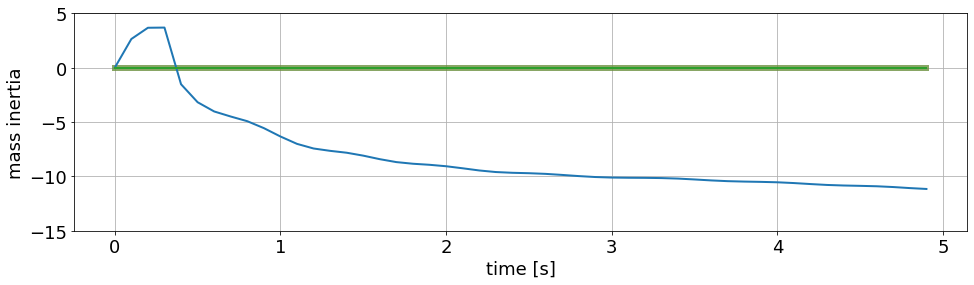

In [51]:
ax_p.set_ylim(-15, 5)
ax_p.set_ylabel('mass inertia')
ax_p.set_xlabel('time [s]')
fig_p

Thank you, for following through this short example on how to use **do-mpc**. We hope you find the tool and this documentation useful.

We also want to emphasize that we skipped over many details, further functions etc. in this introduction. Please have a look at our more complex examples to get a better impression of the possibilities with **do-mpc**.